In [56]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno 

os.chdir("D:\Project_II\plots")

In [58]:
df = pd.read_pickle("df_targets.pkl")

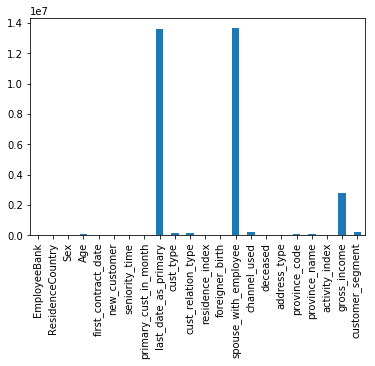

In [59]:
#### NA visualization
df.loc[:,:"customer_segment"].isna().sum().plot(kind="bar")


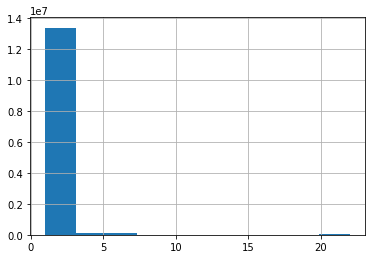

In [60]:
### na frequency per rows 
df.loc[:,:"customer_segment"].isna().sum(axis=1).hist()

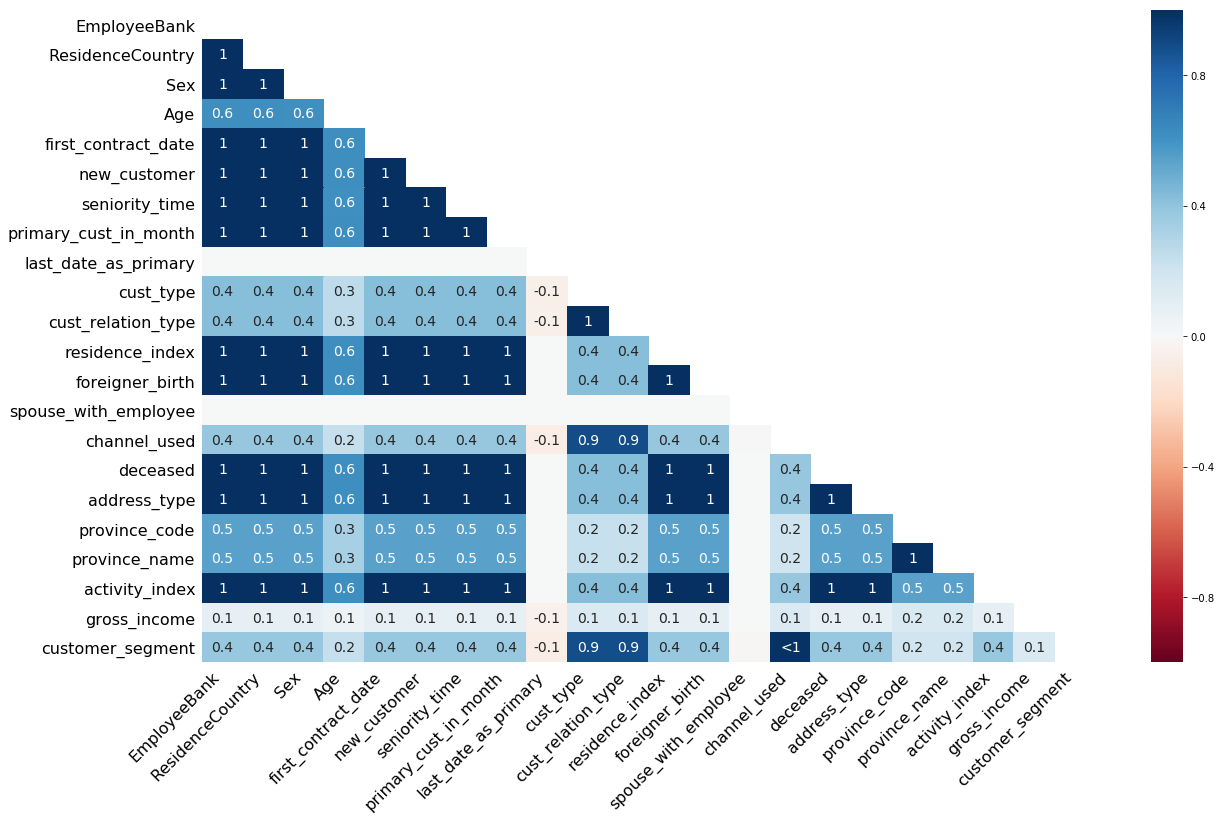

In [61]:
### is there a systematic dependence between NA values?
missingno.heatmap(df.loc[:,:"customer_segment"])

In [62]:
#### first removals:
### spouse_with_employee, last_date_as_primary,
### desceased ones True // we cannot predict anything on deceased ones
### province_code// same info as province_name
### drop na values in basket as well 
df.drop(["spouse_with_employee","last_date_as_primary","province_code"],axis=1,inplace=True)



In [70]:
mask = (df["Payroll"].isna()) | (df["Pension"].isna())


In [77]:
df = df[~mask].copy()


(13596487, 69)

(13612547, 69)

In [78]:
def replace_NA_Persons(df,colX):
    colM = df[colX].copy()
    masK = colM.isna().to_numpy()
    iDD = colM[masK].reset_index("id")["id"]
    to_searchIN = colM.reset_index("Date")
    to_search = to_searchIN.loc[set(iDD),:]    
    to_searchIN = to_search.reset_index("id")
    if df.dtypes[colX] =="float64":
        replS = to_searchIN.groupby("id")[colX].mean()
    else:
        replS = to_searchIN.groupby("id")[colX].apply(lambda x: x.unique()[0])
    replacing = dict(zip(replS.index.values.tolist(),replS.tolist()))
    colK = colM[masK]
    ixx = colK.index
    colV = colK.reset_index("id")
    res=colV["id"].map(replacing).to_numpy()
    colM[masK] = res       
    return(colM) 
    

In [81]:
cols = ["Sex","Age","seniority_time","cust_type","cust_relation_type","channel_used","province_name",
        "gross_income","customer_segment"]


for col in cols:
    df[col] = replace_NA_Persons(df,col)
    

In [83]:
df.isna().sum()[:19]

EmployeeBank               11888
ResidenceCountry           11888
Sex                        11958
Age                        49666
first_contract_date        11888
new_customer               11888
seniority_time             11289
primary_cust_in_month      11888
cust_type                 133909
cust_relation_type        133913
residence_index            11888
foreigner_birth            11888
channel_used              167508
deceased                   11888
address_type               11889
province_name              77263
activity_index             11888
gross_income             2778637
customer_segment          170698
Saving_Account                 0
dtype: int64

In [91]:
df.isna().sum(axis=1).value_counts()
####
#### there are 11255 rows which are full of NA readings in their clients' features
### moreover, there are 89K wih 5 NA readings 
### it is fairly difficult to find a proper reasoning to replace these values with lookup tables

0     10731005
1      2625309
2        93763
5        89828
4        32002
3        12296
19       11255
17         502
6          396
16         131
dtype: int64

In [92]:
rem_mask = df.isna().sum(axis=1) >10

In [96]:
df = df[~rem_mask.to_numpy()]

In [98]:
df.isna().sum()[:19]

EmployeeBank                   0
ResidenceCountry               0
Sex                           70
Age                        38411
first_contract_date            0
new_customer                   0
seniority_time                34
primary_cust_in_month          0
cust_type                 122021
cust_relation_type        122025
residence_index                0
foreigner_birth                0
channel_used              155620
deceased                       0
address_type                   1
province_name              65375
activity_index                 0
gross_income             2766880
customer_segment          158810
dtype: int64

In [99]:
(df.cust_relation_type.isna() & df.cust_type.isna()).sum()

122021

In [109]:
## the function defines a lookup table 
def lookuptable(colX,mm):
    colNA = mm[colX]
    mask = colNA.isna().to_numpy()
    NAfield = mm[mask].loc[:,:"customer_segment"].copy()
    NONA = mm[~mask].loc[:,:"customer_segment"].copy()
    
    colto_use = NAfield.isna().sum() ==0
    colto_use[colX]=True
    
    NAfield= NAfield[colto_use.index[colto_use]]
    NONA = NONA[colto_use.index[colto_use]]
    
    NONA.reset_index("id",inplace=True)    
    NONA.drop_duplicates("id",inplace=True)    
    NONA.drop("id",axis=1,inplace=True)
   
    refCOL = NONA[colX]
    for g in NONA.columns:
        if NONA.dtypes[g].name =="float64":
            NONA[g] = pd.qcut(NONA[g],10,duplicates="drop")
    
    refTabel = NONA.groupby(colX)[NONA.columns.drop(colX)].apply(lambda x: x.mode())
    r_1 = pd.concat([NONA[colX],refCOL],axis=1)
    r_1.columns = [colX,colX+"_"]
    if mm.dtypes[colX].name=="category":
        meanS = refTabel.reset_index(level=0)[colX].values
    else:
        meanS =  r_1.groupby(colX).mean().to_numpy()    
    xa = NAfield.pop(colX)
    xa = xa.to_numpy()
    xa1 = NONA.pop(colX)
    for gg in range(refTabel.shape[0]):
        booLK = refTabel.iloc[gg,:] == NAfield
        xa[np.where(booLK.sum(axis=1)> NAfield.shape[1]-5 )] = meanS[gg]
    
    output_col = mm[colX].copy()
    output_col.loc[NAfield.index] = xa    
    return(output_col)




2

In [111]:
nacols = ["Sex","Age","seniority_time","cust_type","cust_relation_type","channel_used","province_name","gross_income","customer_segment",
         "first_contract_date"]

for ff in nacols:
    df[ff] = lookuptable(ff,df)



C:\Users\SMA\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [117]:
df.isna().sum()[:20]


EmployeeBank                 0
ResidenceCountry             0
Sex                         29
Age                         24
first_contract_date          0
new_customer                 0
seniority_time              34
primary_cust_in_month        0
cust_type                    2
cust_relation_type           4
residence_index              0
foreigner_birth              0
channel_used                 2
deceased                     0
address_type                 1
province_name            59961
activity_index               0
gross_income             77483
customer_segment           657
Saving_Account               0
dtype: int64

In [121]:
## A couple of NA values have not been replaced possibly due to ambiguities in the lookup frame
## they will be removed; moreover, the column deceased is getting removed as well due unique values
df.dropna(axis=0,inplace=True)

C:\Users\SMA\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


77483